In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import cftime

import scipy as scipy

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

def update_leads(x):
    """Converts from time coordinates to lead coordinates.
    I.e., lead days.
    """
    x = x.rename({"time": "lead"})
    x = x.assign_coords(lead=np.arange(x.lead.size).astype(int))
    
    return x

def drop_duplicates_along_all_dims(obj, keep=False):
    deduplicated = obj
    for dim in obj.dims:
        indexes = {dim: ~deduplicated.get_index(dim).duplicated(keep=keep)}
        deduplicated = deduplicated.isel(indexes)
    return deduplicated

In [3]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="00:50:00",
    account="P93300041",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

cluster.scale(8)
client.wait_for_workers(8)


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42779 instead
  warnings.warn(


In [45]:
client.close()

In [3]:
# # Scheduler address from the launch_cluster notebook.
# from dask.distributed import Client

# client = Client("tcp://128.117.208.179:46557")

## Read in simulations 

In [4]:
%%time
ctrlDirs = np.sort(glob.glob('/glade/derecho/scratch/ssfcst/archive/cesm2cam6_noahMP_2021-06-01.*'))
dryDirs  = np.sort(glob.glob('/glade/derecho/scratch/ssfcst/archive/cesm2cam6_noahMP_lowSM_2021-06-01.*'))
wetDirs  = np.sort(glob.glob('/glade/derecho/scratch/ssfcst/archive/cesm2cam6_noahMP_highSM_2021-06-01.*'))

for iEns in range(11): 
    keepVars       = ['SOILWATER_10CM']
    keepVarsAtm    = ['TREFHT','LHFLX','SHFLX','PRECT','Z500','PS',]
    keepVarsAtm_h3 = ['OMEGA500']
    
    ## Get DS in CTRL
    DS_lnd_ctrl_ens = xr.open_dataset(np.sort(glob.glob(ctrlDirs[iEns]+'/lnd/hist/*'))[0])
    DS_lnd_ctrl_ens = DS_lnd_ctrl_ens.assign_coords({"ens":  iEns})
    DS_atm_ctrl_ens = xr.open_dataset(np.sort(glob.glob(ctrlDirs[iEns]+'/atm/hist/*h2*'))[0])
    DS_atm_ctrl_ens = DS_atm_ctrl_ens.assign_coords({"ens":  iEns})
    DS_atm_ctrl_ens_h3 = xr.open_dataset(np.sort(glob.glob(ctrlDirs[iEns]+'/atm/hist/*h3*'))[0])
    DS_atm_ctrl_ens_h3 = DS_atm_ctrl_ens_h3.assign_coords({"ens":  iEns})
    if iEns==0:
        lndDS_ctrl = DS_lnd_ctrl_ens[keepVars]
        atmDS_ctrl = DS_atm_ctrl_ens[keepVarsAtm]
        atmDS_h3_ctrl = DS_atm_ctrl_ens_h3[keepVarsAtm_h3]
    else:
        lndDS_ctrl = xr.concat([lndDS_ctrl, DS_lnd_ctrl_ens[keepVars]], "ens")
        atmDS_ctrl = xr.concat([atmDS_ctrl, DS_atm_ctrl_ens[keepVarsAtm]], "ens")
        atmDS_h3_ctrl = xr.concat([atmDS_h3_ctrl, DS_atm_ctrl_ens_h3[keepVarsAtm_h3]], "ens")
    
    ## Get land DS in Dry
    DS_lnd_dry_ens = xr.open_dataset(np.sort(glob.glob(dryDirs[iEns]+'/lnd/hist/*'))[0])
    DS_lnd_dry_ens = DS_lnd_dry_ens.assign_coords({"ens":  iEns})
    DS_atm_dry_ens = xr.open_dataset(np.sort(glob.glob(dryDirs[iEns]+'/atm/hist/*h2*'))[0])
    DS_atm_dry_ens = DS_atm_dry_ens.assign_coords({"ens":  iEns})
    DS_atm_dry_ens_h3 = xr.open_dataset(np.sort(glob.glob(dryDirs[iEns]+'/atm/hist/*h3*'))[0])
    DS_atm_dry_ens_h3 = DS_atm_dry_ens_h3.assign_coords({"ens":  iEns})
    if iEns==0:
        lndDS_dry = DS_lnd_dry_ens[keepVars]
        atmDS_dry = DS_atm_dry_ens[keepVarsAtm]
        atmDS_h3_dry = DS_atm_dry_ens_h3[keepVarsAtm_h3]
    else:
        lndDS_dry = xr.concat([lndDS_dry, DS_lnd_dry_ens[keepVars]], "ens")
        atmDS_dry = xr.concat([atmDS_dry, DS_atm_dry_ens[keepVarsAtm]], "ens")
        atmDS_h3_dry = xr.concat([atmDS_h3_dry, DS_atm_dry_ens_h3[keepVarsAtm_h3]], "ens")

    ## Get land DS in Wet
    DS_lnd_wet_ens = xr.open_dataset(np.sort(glob.glob(wetDirs[iEns]+'/lnd/hist/*'))[0])
    DS_lnd_wet_ens = DS_lnd_wet_ens.assign_coords({"ens":  iEns})
    DS_atm_wet_ens = xr.open_dataset(np.sort(glob.glob(wetDirs[iEns]+'/atm/hist/*h2*'))[0])
    DS_atm_wet_ens = DS_atm_wet_ens.assign_coords({"ens":  iEns})
    DS_atm_wet_ens_h3 = xr.open_dataset(np.sort(glob.glob(wetDirs[iEns]+'/atm/hist/*h3*'))[0])
    DS_atm_wet_ens_h3 = DS_atm_wet_ens_h3.assign_coords({"ens":  iEns})
    if iEns==0:
        lndDS_wet = DS_lnd_wet_ens[keepVars]
        atmDS_wet = DS_atm_wet_ens[keepVarsAtm]
        atmDS_h3_wet = DS_atm_wet_ens_h3[keepVarsAtm_h3]
    else:
        lndDS_wet = xr.concat([lndDS_wet, DS_lnd_wet_ens[keepVars]], "ens")
        atmDS_wet = xr.concat([atmDS_wet, DS_atm_wet_ens[keepVarsAtm]], "ens")
        atmDS_h3_wet = xr.concat([atmDS_h3_wet, DS_atm_wet_ens_h3[keepVarsAtm_h3]], "ens")



CPU times: user 5.45 s, sys: 31.2 s, total: 36.6 s
Wall time: 1min 38s


In [ ]:
# dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoLND/archive/'

# for iEns in range(11):
#     if iEns<10: 
#         listFiles = np.sort(glob.glob(dataDir+'*.0'+str(iEns)+'.clm2.h0.????-06-21-*.nc'))
#     else: 
#         listFiles = np.sort(glob.glob(dataDir+'*.'+str(iEns)+'.clm2.h0.????-06-21-*.nc'))

#     DS_lnd_ens = xr.open_mfdataset(listFiles, preprocess=process_lnd, concat_dim='time', 
#                                 combine='nested', decode_times=True, 
#                                 data_vars='minimal')
    
#     DS_lnd_ens = DS_lnd_ens.assign_coords({"ens":  iEns})

#     if iEns==0:
#         hindcast_DS = DS_lnd_ens
#     else: 
#         hindcast_DS = xr.concat([hindcast_DS, DS_lnd_ens], "ens") 

#     print('Done with ens member ', iEns)
    

## Focus in on Pacific NW 

In [5]:
iStart = np.where((atmDS_ctrl['time.month'].values==6) & (atmDS_ctrl['time.day'].values==26))[0]
iEnd   = np.where((atmDS_ctrl['time.month'].values==7) & (atmDS_ctrl['time.day'].values==1))[0]

In [6]:
print(iStart, iEnd)

[25] [30]


In [7]:
## Average over heatwave period: 
atmDS_ctrl_hw =  atmDS_ctrl.isel(time= np.arange(int(iStart[0]),int(iEnd[0]+1)) ).mean(dim='time')
atmDS_dry_hw  =  atmDS_dry.isel(time= np.arange(int(iStart[0]),int(iEnd[0]+1)) ).mean(dim='time')
atmDS_wet_hw  =  atmDS_wet.isel(time= np.arange(int(iStart[0]),int(iEnd[0]+1)) ).mean(dim='time')

lndDS_ctrl_hw =  lndDS_ctrl.isel(time= np.arange(int(iStart[0]),int(iEnd[0]+1)) ).mean(dim='time')
lndDS_dry_hw  =  lndDS_dry.isel(time= np.arange(int(iStart[0]),int(iEnd[0]+1)) ).mean(dim='time')
lndDS_wet_hw  =  lndDS_wet.isel(time= np.arange(int(iStart[0]),int(iEnd[0]+1)) ).mean(dim='time')


In [5]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')


In [9]:
## A few plot options that are a bit more generic 
longrid, latgrid = np.meshgrid(atmDS_ctrl_hw['lon'], atmDS_ctrl_hw['lat'] )
normVar_TREFHT = matplotlib.colors.Normalize(vmin=280, vmax=305)
normVar_diff_TREFHT = matplotlib.colors.Normalize(vmin=-5, vmax=5)


Text(0.5, 1.0, 'Ensemble Mean TREFHT: WET-CTRL')

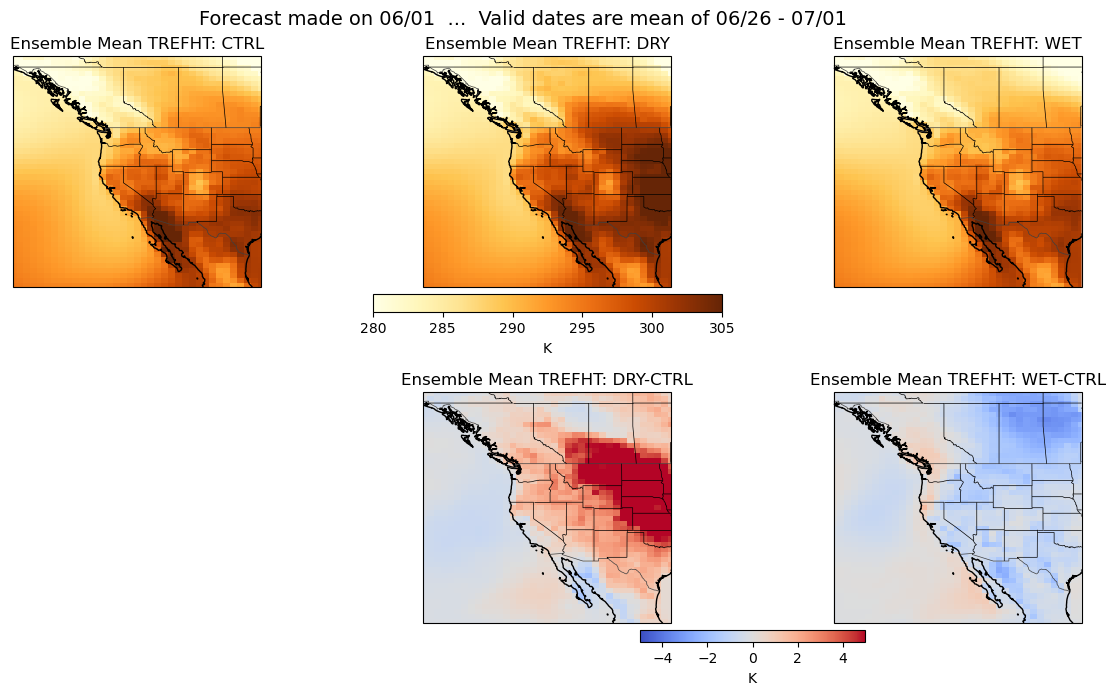

In [68]:
fig,axs = plt.subplots(2,3, figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([220,265,20,60]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.28,0.92,'Forecast made on 06/01  ...  Valid dates are mean of 06/26 - 07/01 ',fontsize=14)


# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(atmDS_ctrl_hw.TREFHT.mean(dim='ens').values), 
                  cmap='YlOrBr', norm=normVar_TREFHT, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean TREFHT: CTRL')

p1 =axs[1].pcolormesh(longrid,latgrid, np.squeeze(atmDS_dry_hw.TREFHT.mean(dim='ens').values), 
                  cmap='YlOrBr', norm=normVar_TREFHT, transform=ccrs.PlateCarree())
axs[1].set_title('Ensemble Mean TREFHT: DRY')
# Add colorbar
cb = fig.colorbar(p1, ax=axs[0:3], shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

axs[2].pcolormesh(longrid,latgrid, np.squeeze(atmDS_wet_hw.TREFHT.mean(dim='ens').values), 
                  cmap='YlOrBr', norm=normVar_TREFHT, transform=ccrs.PlateCarree())
axs[2].set_title('Ensemble Mean TREFHT: WET')

fig.delaxes(axs[3])

p2 =axs[4].pcolormesh(longrid,latgrid, np.squeeze(atmDS_dry_hw.TREFHT.mean(dim='ens').values) - np.squeeze(atmDS_ctrl_hw.TREFHT.mean(dim='ens').values), 
                  cmap='coolwarm', norm=normVar_diff_TREFHT, transform=ccrs.PlateCarree())
axs[4].set_title('Ensemble Mean TREFHT: DRY-CTRL')
# Add colorbar
cb = fig.colorbar(p2, ax=axs[4::], shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

axs[5].pcolormesh(longrid,latgrid, np.squeeze(atmDS_wet_hw.TREFHT.mean(dim='ens').values) - np.squeeze(atmDS_ctrl_hw.TREFHT.mean(dim='ens').values), 
                  cmap='coolwarm', norm=normVar_diff_TREFHT, transform=ccrs.PlateCarree())
axs[5].set_title('Ensemble Mean TREFHT: WET-CTRL')


## But really, I need to know the anomaly. So what is that? 

In [6]:
model = "CESM2"
data = "climatology" #raw or anom or climatology

hinda = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+"."+data+".daily.geospatial.zarr/", consolidated=True).astype('float32')


In [7]:
hinda["lead"] = range(0,46)

In [12]:
# Select climo for June 1st
climo = hinda.sel(dayofyear=152)

In [13]:
## Need to regrid the special test case to match lat/lon in climo... 
regrid_ctrl = regrid_data(atmDS_ctrl.reindex(lat=list(reversed(atmDS_ctrl.lat))), climo, method=1)
regrid_dry  = regrid_data(atmDS_dry.reindex(lat=list(reversed(atmDS_dry.lat))),   climo, method=1)
regrid_wet  = regrid_data(atmDS_wet.reindex(lat=list(reversed(atmDS_wet.lat))),   climo, method=1)


In [113]:
# Get anomalies for T2M 
regrid_ctrl = regrid_ctrl.rename({'time': 'lead'})
regrid_ctrl['lead'] = climo['lead']
anom_ctrl = regrid_ctrl['TREFHT'] - climo['t2m']

regrid_dry = regrid_dry.rename({'time': 'lead'})
regrid_dry['lead'] = climo['lead']
anom_dry = regrid_dry['TREFHT'] - climo['t2m']

regrid_wet = regrid_wet.rename({'time': 'lead'})
regrid_wet['lead'] = climo['lead']
anom_wet = regrid_wet['TREFHT'] - climo['t2m']


In [120]:
anom_ctrl_avg = anom_ctrl.mean(dim='ens').isel(lead=np.arange(iStart[0],iEnd[0]+1)).mean(dim='lead')
anom_dry_avg  = anom_dry.mean(dim='ens').isel(lead=np.arange(iStart[0],iEnd[0]+1)).mean(dim='lead')
anom_wet_avg  = anom_wet.mean(dim='ens').isel(lead=np.arange(iStart[0],iEnd[0]+1)).mean(dim='lead')


In [126]:
longrid_anom, latgrid_anom = np.meshgrid(anom_ctrl_avg['lon'], anom_ctrl_avg['lat'] )
normVar_anom  = matplotlib.colors.Normalize(vmin=-6, vmax=6)



In [143]:
import warnings
warnings.filterwarnings("ignore")

Text(0.5, 1.0, 'Ensemble Mean Anomalous TREFHT: WET')

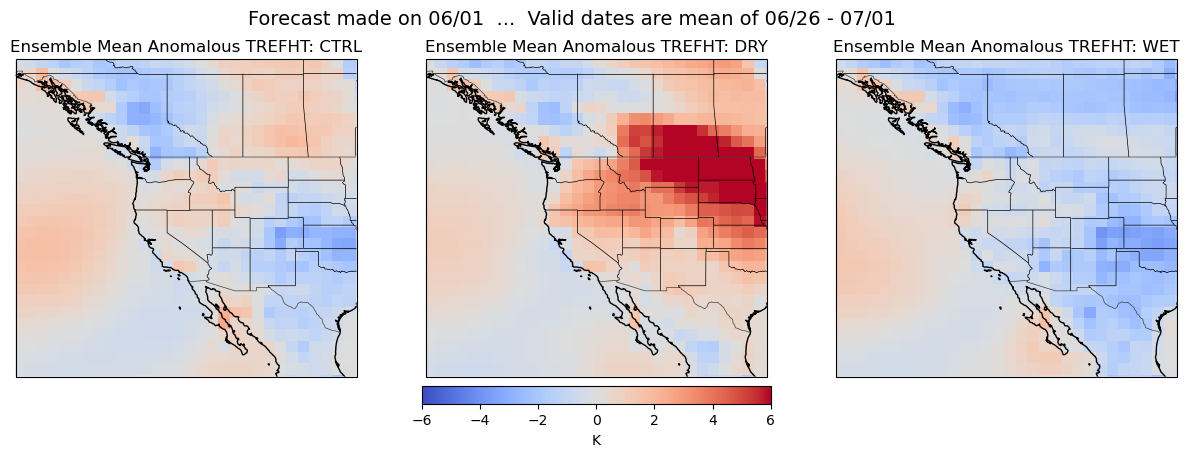

In [144]:
fig,axs = plt.subplots(1,3, figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([220,265,20,60]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.28,0.95,'Forecast made on 06/01  ...  Valid dates are mean of 06/26 - 07/01 ',fontsize=14)

# Plot ens mean 
axs[0].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_ctrl_avg.values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean Anomalous TREFHT: CTRL')

p1 =axs[1].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_dry_avg.values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[1].set_title('Ensemble Mean Anomalous TREFHT: DRY')
# Add colorbar
cb = fig.colorbar(p1, ax=axs[0:3], shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

axs[2].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_wet_avg.values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[2].set_title('Ensemble Mean Anomalous TREFHT: WET')


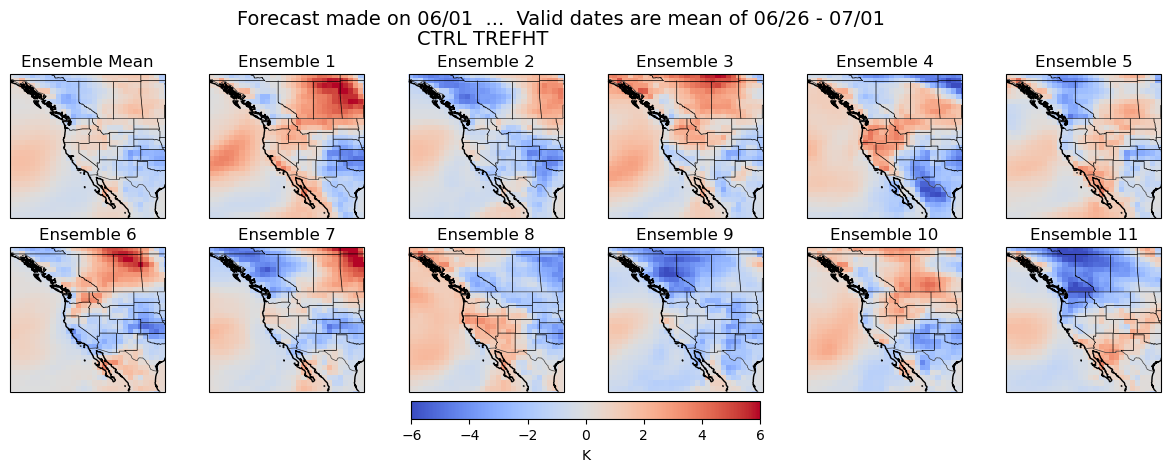

In [145]:
anom_ctrl_ens = anom_ctrl.isel(lead=np.arange(iStart[0],iEnd[0]+1)).mean(dim='lead')

fig,axs = plt.subplots(2,6, figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([220,265,20,60]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.28,0.98,'Forecast made on 06/01  ...  Valid dates are mean of 06/26 - 07/01 ',fontsize=14)
fig.text(0.4,0.94,'CTRL TREFHT ',fontsize=14)


for iEns in range(len(anom_ctrl.ens.values)+1):
    if iEns==0: 
        # Plot ens mean 
        axs[0].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_ctrl_avg.values), 
                          cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
        axs[0].set_title('Ensemble Mean')
    else: 
        p1= axs[iEns].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_ctrl_ens.isel(ens=iEns-1).values), 
                          cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
        axs[iEns].set_title('Ensemble '+str(iEns))

cb = fig.colorbar(p1, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

plt.show()

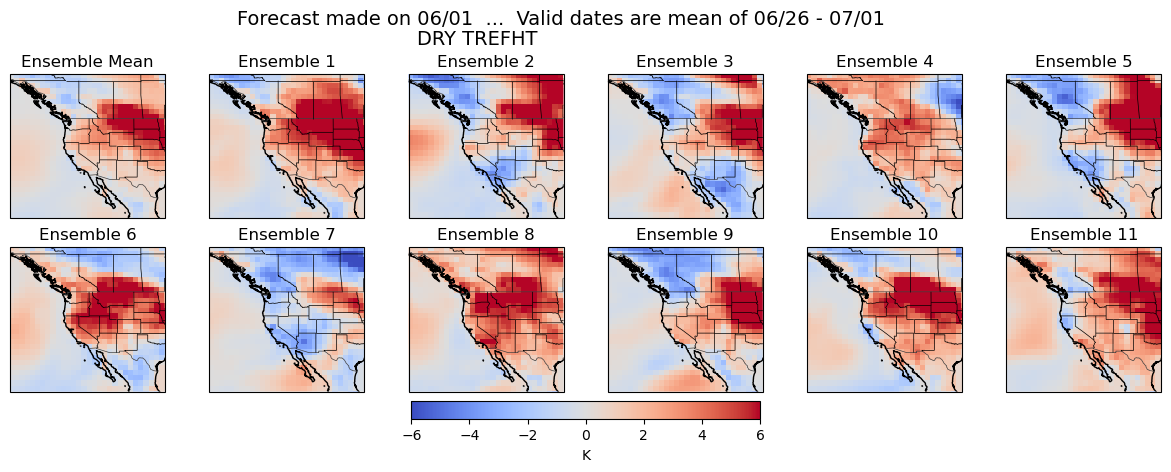

In [147]:
anom_dry_ens = anom_dry.isel(lead=np.arange(iStart[0],iEnd[0]+1)).mean(dim='lead')

fig,axs = plt.subplots(2,6, figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([220,265,20,60]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.28,0.98,'Forecast made on 06/01  ...  Valid dates are mean of 06/26 - 07/01 ',fontsize=14)
fig.text(0.4,0.94,'DRY TREFHT ',fontsize=14)


for iEns in range(len(anom_ctrl.ens.values)+1):
    if iEns==0: 
        # Plot ens mean 
        axs[0].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_dry_avg.values), 
                          cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
        axs[0].set_title('Ensemble Mean')
    else: 
        p1= axs[iEns].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_dry_ens.isel(ens=iEns-1).values), 
                          cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
        axs[iEns].set_title('Ensemble '+str(iEns))

cb = fig.colorbar(p1, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

plt.show()

## Did skill get better with forecasts made closer to the heat wave? 

In [8]:
def get_fcstDS(init):
    # init = fcst_init[iFcst]
    filelist = np.sort(glob.glob(dataDir+'*'+init+'_00z_d01_d46*.nc'))

    # Open all ensemble members for a given init.
    ds = xr.open_mfdataset(
        filelist,
        combine="nested",
        parallel=True,
        concat_dim="member",
        preprocess=drop_duplicates_along_all_dims,
        chunks = {"time": -1, "lon": -1, "lat": -1},
        # speeds things up a bit
        coords="minimal",
        compat="override",
    ).rename({"time": "lead"})

    # Derive datetime for initialization based on the string in the filename.
    MON_TO_INT = {
        "jan": 1,
        "feb": 2,
        "mar": 3,
        "apr": 4,
        "may": 5,
        "jun": 6,
        "jul": 7,
        "aug": 8,
        "sep": 9,
        "oct": 10,
        "nov": 11,
        "dec": 12,
    }

    day = init[0:2]
    mon = init[2:5]
    mon = MON_TO_INT[mon]
    year = init[5::]

    # Assign initialization year and member numbers as coordinates.
    ds = ds.assign_coords(
        lead=np.arange(ds.lead.size).astype(int),
        init=cftime.DatetimeNoLeap(int(year), int(mon), int(day)),
        member=np.arange(ds[var].shape[0]) + 1,
#        member=np.arange(5) + 1,
    )

    # Chunk into one chunk. About 100MB per initialization
    # (full globe, all leads, all members)
    ds = ds.chunk({"member": -1})

    return ds


In [9]:
dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2021/06/'

fcst_init = ['07jun2021',
             '14jun2021',
             '21jun2021',
            ]
var = 'tas_2m'


ds_0607 = get_fcstDS(fcst_init[0])
ds_0614 = get_fcstDS(fcst_init[1])
ds_0621 = get_fcstDS(fcst_init[2])


In [10]:
# Select climo for each start date
climo_0607 = hinda.sel(dayofyear=158)
climo_0614 = hinda.sel(dayofyear=165)
climo_0621 = hinda.sel(dayofyear=172)


In [11]:
## - - - Get anomalies - - - 

# regrid first? 
regrid_ds_0607 = regrid_data(ds_0607.reindex(lat=list(reversed(ds_0607.lat))), climo_0607, method=1)
regrid_ds_0614 = regrid_data(ds_0614.reindex(lat=list(reversed(ds_0614.lat))), climo_0614, method=1)
regrid_ds_0621 = regrid_data(ds_0621.reindex(lat=list(reversed(ds_0621.lat))), climo_0621, method=1)

# regrid_ds_0607 = regrid_ds_0607.rename({'time': 'lead'})
# regrid_ds_0614 = regrid_ds_0614.rename({'time': 'lead'})
# regrid_ds_0621 = regrid_ds_0621.rename({'time': 'lead'})
# regrid_ctrl['lead'] = climo['lead']

# Compute actual anomalies
# anom_0607 = ds_0607['tas_2m'] - climo_0607['t2m']
# anom_0614 = ds_0614['tas_2m'] - climo_0614['t2m']
# anom_0621 = ds_0621['tas_2m'] - climo_0621['t2m']
anom_0607 = regrid_ds_0607['tas_2m'] - climo_0607['t2m']
anom_0614 = regrid_ds_0614['tas_2m'] - climo_0614['t2m']
anom_0621 = regrid_ds_0621['tas_2m'] - climo_0621['t2m']



In [77]:
## What if anomalies are just removing climatology, not lead-dependent bias??

# This seems harder than I first thought. The climatology we have computed in hinda is still 
#   based on 45-day reforecasts, conducted over 20 years. That's just different than if we had
#   a 20-year free running simulation to compute climatology over. Since this is fully coupled 
#   and with BGC active, my existing runs aren't going to be right to get that climo from either.
# 
#   So the question then is does Sasha have output/climo from that long run, which I assume was 
#   used to generate the initial conditions from? 

times_0607 = np.array([ds_0607.init.values  + timedelta(days=int(lead)) for lead in ds_0607.lead.values])
times_0614 = np.array([ds_0614.init.values  + timedelta(days=int(lead)) for lead in ds_0614.lead.values])
times_0621 = np.array([ds_0621.init.values  + timedelta(days=int(lead)) for lead in ds_0621.lead.values])

# First pass though, I could remove the climatology only... it's just not right, ultimately 

# Select climo for each start date
lead0_0607 = hinda.sel(lead=0).sel(dayofyear=slice(158, 158+45))
lead0_0614 = hinda.sel(lead=0).sel(dayofyear=slice(165, 165+45))
lead0_0621 = hinda.sel(lead=0).sel(dayofyear=slice(172, 172+45))

lead0_0607=lead0_0607.rename({"dayofyear": "time"})
lead0_0614=lead0_0614.rename({"dayofyear": "time"})
lead0_0621=lead0_0621.rename({"dayofyear": "time"})
lead0_0607["time"] = range(0,46)
lead0_0614["time"] = range(0,46)
lead0_0621["time"] = range(0,46)

ds_0607=ds_0607.rename({"lead": "time"})
ds_0614=ds_0614.rename({"lead": "time"})
ds_0621=ds_0621.rename({"lead": "time"})

# Get anomalies 
anomOnly_0607 = ds_0607['tas_2m'] - lead0_0607['t2m']
anomOnly_0614 = ds_0614['tas_2m'] - lead0_0614['t2m']
anomOnly_0621 = ds_0621['tas_2m'] - lead0_0621['t2m']

# Get mean over 6/26 - 7/01 
anomOnly_0607_avg = anomOnly_0607.isel(time=np.arange(19,25)).mean(dim='time')
anomOnly_0614_avg = anomOnly_0614.isel(time=np.arange(12,18)).mean(dim='time')
anomOnly_0621_avg = anomOnly_0621.isel(time=np.arange(5,11)).mean(dim='time')


In [12]:
# Get mean over 6/26 - 7/02 
anom_0607_avg = anom_0607.isel(lead=np.arange(19,26)).mean(dim='lead')
anom_0614_avg = anom_0614.isel(lead=np.arange(12,19)).mean(dim='lead')
anom_0621_avg = anom_0621.isel(lead=np.arange(5,12)).mean(dim='lead')


# # Get mean over 6/28 - 7/04 
# anom_0607_avg = anom_0607.isel(lead=np.arange(21,28)).mean(dim='lead')
# anom_0614_avg = anom_0614.isel(lead=np.arange(14,21)).mean(dim='lead')
# anom_0621_avg = anom_0621.isel(lead=np.arange(7,14)).mean(dim='lead')


In [13]:
longrid_anom, latgrid_anom = np.meshgrid(anom_0607['lon'], anom_0607['lat'] )
normVar_anom  = matplotlib.colors.Normalize(vmin=-6, vmax=6)



Text(0.5, 1.0, 'Ensemble Mean Anomalous TREFHT: Init 06/21')

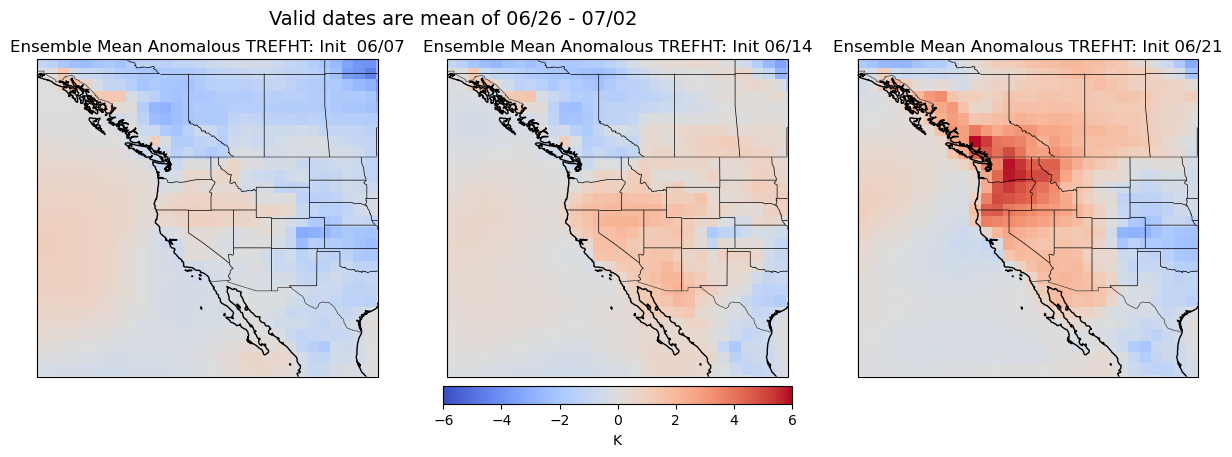

In [14]:
fig,axs = plt.subplots(1,3, figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([220,265,20,60]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.28,0.95,'Valid dates are mean of 06/26 - 07/02 ',fontsize=14)
# fig.text(0.28,0.95,'Valid dates are mean of 06/28 - 07/04 ',fontsize=14)

# Plot ens mean 
axs[0].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_0607_avg.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean Anomalous TREFHT: Init  06/07')

p1 =axs[1].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_0614_avg.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[1].set_title('Ensemble Mean Anomalous TREFHT: Init 06/14')
# Add colorbar
cb = fig.colorbar(p1, ax=axs[0:3], shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

axs[2].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_0621_avg.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[2].set_title('Ensemble Mean Anomalous TREFHT: Init 06/21')


In [ ]:
longrid_anom, latgrid_anom = np.meshgrid(anomOnly_0607['lon'], anomOnly_0607['lat'] )
normVar_anom  = matplotlib.colors.Normalize(vmin=-6, vmax=6)



Text(0.5, 1.0, 'Ensemble Mean Anomalous [no lead-dependent] TREFHT: Init 06/21')

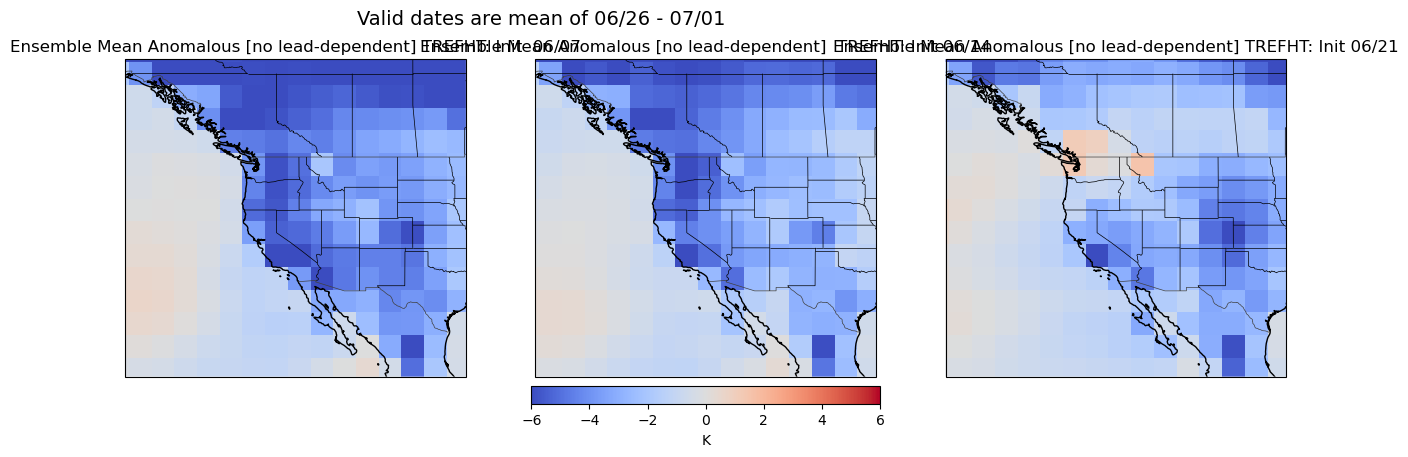

In [79]:
fig,axs = plt.subplots(1,3, figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([220,265,20,60]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.28,0.95,'Valid dates are mean of 06/26 - 07/01 ',fontsize=14)

# Plot ens mean 
axs[0].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anomOnly_0607_avg.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean Anomalous [no lead-dependent] TREFHT: Init  06/07')

p1 =axs[1].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anomOnly_0614_avg.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[1].set_title('Ensemble Mean Anomalous [no lead-dependent]  TREFHT: Init 06/14')
# Add colorbar
cb = fig.colorbar(p1, ax=axs[0:3], shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

axs[2].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anomOnly_0621_avg.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[2].set_title('Ensemble Mean Anomalous [no lead-dependent] TREFHT: Init 06/21')


## Is there a clear progression of soil moisture anomalies to go along with above...? 

In [15]:
# Steps: compute soil moisture file concat; compute climo; use to compute anomalies here? 
raw_soil  = xr.open_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/cesm2cam6v2.raw.daily.SOILWATER10CM.geospatial.zarr",consolidated=True)
clim_soil = xr.open_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/cesm2cam6v2.climatology.daily.SOILWATER10CM.geospatial.zarr",consolidated=True) 



In [102]:
raw_soil

<xarray.Dataset> Size: 131GB
Dimensions:         (member: 11, init: 1168, lead: 46, lat: 192, lon: 288)
Coordinates:
  * init            (init) datetime64[ns] 9kB 1999-01-04 ... 2023-10-30
  * lat             (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lead            (lead) int64 368B 0 1 2 3 4 5 6 7 ... 39 40 41 42 43 44 45
  * lon             (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * member          (member) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    SOILWATER_10CM  (member, init, lead, lat, lon) float32 131GB dask.array<chunksize=(11, 1, 46, 192, 288), meta=np.ndarray>

In [16]:
raw_time_0607 = np.where((raw_soil['init.year']==2021) & (raw_soil['init.month']==6) & (raw_soil['init.day']==7) )[0][0]
raw_soil_0607 = raw_soil.isel(init=raw_time_0607)

raw_time_0614 = np.where((raw_soil['init.year']==2021) & (raw_soil['init.month']==6) & (raw_soil['init.day']==14) )[0][0]
raw_soil_0614 = raw_soil.isel(init=raw_time_0614)

raw_time_0621 = np.where((raw_soil['init.year']==2021) & (raw_soil['init.month']==6) & (raw_soil['init.day']==21) )[0][0]
raw_soil_0621 = raw_soil.isel(init=raw_time_0621)


In [17]:
# Select climo for each start date
climo_soil_0607 = clim_soil.sel(dayofyear=158)
climo_soil_0614 = clim_soil.sel(dayofyear=165)
climo_soil_0621 = clim_soil.sel(dayofyear=172)

In [18]:
# Get anomalies (don't need to regrid, already common) 
anom_soil_0607 = raw_soil_0607['SOILWATER_10CM'] - climo_soil_0607['SOILWATER_10CM']
anom_soil_0614 = raw_soil_0614['SOILWATER_10CM'] - climo_soil_0614['SOILWATER_10CM']
anom_soil_0621 = raw_soil_0621['SOILWATER_10CM'] - climo_soil_0621['SOILWATER_10CM']


In [48]:
raw_soil_0607['SOILWATER_10CM'].units

'kg/m2'

In [19]:
# # Get mean over 6/26 - 7/01 
# anom_soil_0607_avg = anom_soil_0607.isel(lead=np.arange(19,25)).mean(dim='lead')
# anom_soil_0614_avg = anom_soil_0614.isel(lead=np.arange(12,18)).mean(dim='lead')
# anom_soil_0621_avg = anom_soil_0621.isel(lead=np.arange(5,11)).mean(dim='lead')
# Get mean of 5 days prior to onset of avg time
anom_soil_0607_avg = anom_soil_0607.isel(lead=np.arange(19-5,19)).mean(dim='lead')
anom_soil_0614_avg = anom_soil_0614.isel(lead=np.arange(12-5,12)).mean(dim='lead')
anom_soil_0621_avg = anom_soil_0621.isel(lead=np.arange(0,5)).mean(dim='lead')


# Get mean over 6/28 - 7/04 
# anom_soil_0607_avg = anom_soil_0607.isel(lead=np.arange(21,28)).mean(dim='lead')
# anom_soil_0614_avg = anom_soil_0614.isel(lead=np.arange(14,21)).mean(dim='lead')
# # anom_soil_0621_avg = anom_soil_0621.isel(lead=np.arange(7,14)).mean(dim='lead')

# anom_soil_0621_avg = anom_soil_0621.isel(lead=np.arange(0,7)).mean(dim='lead')

In [40]:
longrid_anom, latgrid_anom = np.meshgrid(anom_soil_0614['lon'], anom_soil_0614['lat'] )
normVar_anom_soil  = matplotlib.colors.Normalize(vmin=-15, vmax=15)



Text(0.5, 1.0, 'Ensemble Mean Anomalous SOILWATER_10CM: \nInit 06/21')

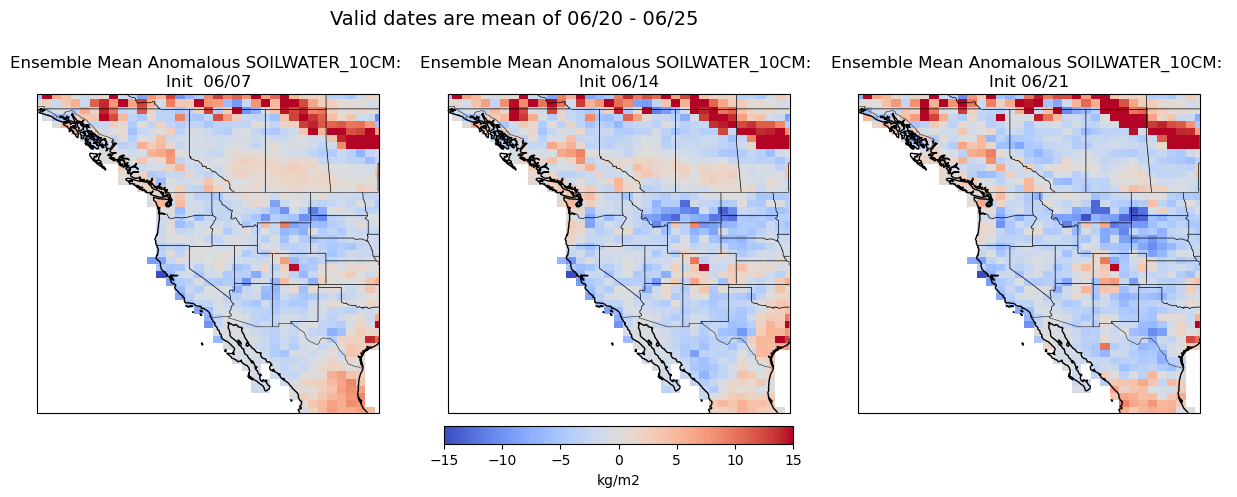

In [44]:
fig,axs = plt.subplots(1,3, figsize=(15,7),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([220,265,20,60]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

# fig.text(0.28,0.95,'Valid dates are mean of 06/26 - 07/01 ',fontsize=14)
# fig.text(0.28,0.95,'Valid dates are mean of 06/28 - 07/04 ',fontsize=14)
fig.text(0.32,0.80,'Valid dates are mean of 06/20 - 06/25 ',fontsize=14)

# Plot ens mean 
axs[0].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_soil_0607_avg.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom_soil, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean Anomalous SOILWATER_10CM: \nInit  06/07')

p1 =axs[1].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_soil_0614_avg.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom_soil, transform=ccrs.PlateCarree())
axs[1].set_title('Ensemble Mean Anomalous SOILWATER_10CM: \nInit 06/14')
# Add colorbar
cb = fig.colorbar(p1, ax=axs[0:3], shrink=0.3, label='kg/m2', orientation='horizontal', pad=0.025) 

axs[2].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_soil_0621_avg.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom_soil, transform=ccrs.PlateCarree())
axs[2].set_title('Ensemble Mean Anomalous SOILWATER_10CM: \nInit 06/21')


## What is the impact of using climo inics? 

In [22]:
def get_fcstDS(dataDir,init):
    # init = fcst_init[iFcst]
    filelist = np.sort(glob.glob(dataDir+'*'+init+'_00z_d01_d46*.nc'))

    # Open all ensemble members for a given init.
    ds = xr.open_mfdataset(
        filelist,
        combine="nested",
        parallel=True,
        concat_dim="member",
        preprocess=drop_duplicates_along_all_dims,
        chunks = {"time": -1, "lon": -1, "lat": -1},
        # speeds things up a bit
        coords="minimal",
        compat="override",
    ).rename({"time": "lead"})

    # Derive datetime for initialization based on the string in the filename.
    MON_TO_INT = {
        "jan": 1,
        "feb": 2,
        "mar": 3,
        "apr": 4,
        "may": 5,
        "jun": 6,
        "jul": 7,
        "aug": 8,
        "sep": 9,
        "oct": 10,
        "nov": 11,
        "dec": 12,
    }

    day = init[0:2]
    mon = init[2:5]
    mon = MON_TO_INT[mon]
    year = init[5::]

    # Assign initialization year and member numbers as coordinates.
    ds = ds.assign_coords(
        lead=np.arange(ds.lead.size).astype(int),
        init=cftime.DatetimeNoLeap(int(year), int(mon), int(day)),
        member=np.arange(ds[var].shape[0]) + 1,
#        member=np.arange(5) + 1,
    )

    # Chunk into one chunk. About 100MB per initialization
    # (full globe, all leads, all members)
    ds = ds.chunk({"member": -1})

    return ds


In [23]:
default_dataDir  = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTS/p1/tas_2m/2021/06/'
climoLnd_dataDir = '/glade/derecho/scratch/ssfcst/cesm2cam6climoLND/p1/tas_2m/2021/06/'
climoALL_dataDir = '/glade/campaign/cesm/development/cross-wg/S2S/CESM2/S2SHINDCASTSclimoALL/postprocess/p1/tas_2m/2010/06/'


fcst_init = [
             '21jun2021',
             '21jun2010',
    
            ]
var = 'tas_2m'

default_0621  = get_fcstDS(default_dataDir,fcst_init[0]).isel(member=slice(0,11))
climoLnd_0621 = get_fcstDS(climoLnd_dataDir,fcst_init[0])
climoAll_0621 = get_fcstDS(climoALL_dataDir,fcst_init[1])


In [24]:
heatwave_default  = default_0621.isel(lead=np.arange(5,12)).mean(dim='lead')
heatwave_climoLnd = climoLnd_0621.isel(lead=np.arange(5,12)).mean(dim='lead')
heatwave_climoAll = climoAll_0621.isel(lead=np.arange(5,12)).mean(dim='lead')

# heatwave_default  = default_0621.isel(lead=np.arange(7,14)).mean(dim='lead')
# heatwave_climoLnd = climoLnd_0621.isel(lead=np.arange(7,14)).mean(dim='lead')
# heatwave_climoAll = climoAll_0621.isel(lead=np.arange(7,14)).mean(dim='lead')


In [25]:
longrid, latgrid = np.meshgrid(heatwave_default['lon'], heatwave_default['lat'] )
normVar  = matplotlib.colors.Normalize(vmin=285, vmax=305)
normVarDiff  = matplotlib.colors.Normalize(vmin=-5, vmax=5)



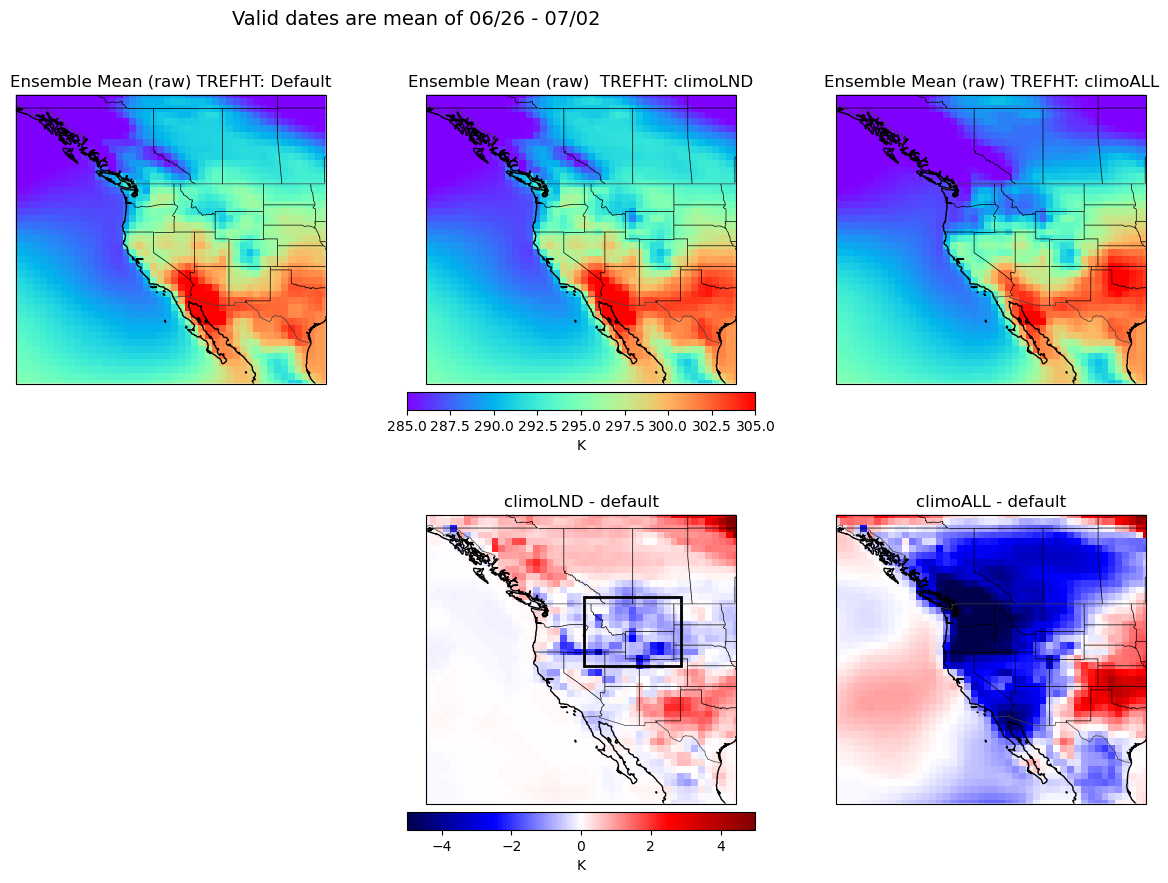

In [26]:
fig,axs = plt.subplots(2,3, figsize=(15,10),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([220,265,20,60]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.28,0.95,'Valid dates are mean of 06/26 - 07/02 ',fontsize=14)
# fig.text(0.28,0.95,'Valid dates are mean of 06/28 - 07/04 ',fontsize=14)

# Plot ens mean 
axs[0].pcolormesh(longrid,latgrid, np.squeeze(heatwave_default.mean(dim='member').tas_2m.values), 
                  cmap='rainbow', norm=normVar, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean (raw) TREFHT: Default')

p1 =axs[1].pcolormesh(longrid,latgrid, np.squeeze(heatwave_climoLnd.mean(dim='member').tas_2m.values), 
                  cmap='rainbow', norm=normVar, transform=ccrs.PlateCarree())
axs[1].set_title('Ensemble Mean (raw)  TREFHT: climoLND')
# Add colorbar
cb = fig.colorbar(p1, ax=axs[0:3], shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

axs[2].pcolormesh(longrid,latgrid, np.squeeze(heatwave_climoAll.mean(dim='member').tas_2m.values), 
                  cmap='rainbow', norm=normVar, transform=ccrs.PlateCarree())
axs[2].set_title('Ensemble Mean (raw) TREFHT: climoALL')

fig.delaxes(axs[3])

p2 =axs[4].pcolormesh(longrid,latgrid, np.squeeze(heatwave_climoLnd.mean(dim='member').tas_2m.values) - np.squeeze(heatwave_default.mean(dim='member').tas_2m.values), 
                  cmap='seismic', norm=normVarDiff, transform=ccrs.PlateCarree())
axs[4].set_title('climoLND - default')
# Add colorbar
cb = fig.colorbar(p2, ax=axs[3:6], shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

axs[5].pcolormesh(longrid,latgrid, np.squeeze(heatwave_climoAll.mean(dim='member').tas_2m.values) - np.squeeze(heatwave_default.mean(dim='member').tas_2m.values), 
                  cmap='seismic', norm=normVarDiff, transform=ccrs.PlateCarree())
axs[5].set_title('climoALL - default')


# Add rectangle?
axs[4].add_patch(patches.Rectangle(xy=[243, 40], width=(257-243), height=(50-40),
                                facecolor='none', edgecolor='k',linestyle='-',
                                linewidth=2, transform=ccrs.PlateCarree()))


<span style="color:blue">So replacing the *actual* soil mositure conditions with *climatological* ones actually leads to WARMER temperatures during the NW heatwave.
<br>
That's counter-intuitive if we expect the impact of soil moisture to be that dry soil moisture anomalies help intensify the heat wave. This would almost indicate that the climatological soil moisture values were drier than the actual soil moisture values that were simulated...
</span> 

In [27]:
## What if we remove climatology? 
model = "CESM2"
data = "climatology" #raw or anom or climatology
hinda_default = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+"."+data+".daily.geospatial.zarr/", consolidated=True).astype('float32')
climo_default_0621 = hinda_default.sel(dayofyear=172)

model = "CESM2_climoLND"
data = "climatology" #raw or anom or climatology
hinda_climoLND = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+"."+data+".daily.geospatial.zarr/", consolidated=True).astype('float32')
climo_climoLND_0621 = hinda_climoLND.sel(dayofyear=172)


In [28]:
# Regrid to get to same grid as anomalies 
regrid_default = regrid_data(default_0621.reindex(lat=list(reversed(default_0621.lat))),    climo_default_0621, method=1)
regrid_climo_climoLND_0621 =  regrid_data(climo_climoLND_0621.reindex(lat=list(reversed(climo_climoLND_0621.lat))),    climo_default_0621, method=1)
regrid_climoLND = regrid_data(climoLnd_0621, regrid_climo_climoLND_0621, method=1)
# regrid_ctrl = regrid_ctrl.rename({'time': 'lead'})
# regrid_ctrl['lead'] = climo['lead']



In [32]:
# Get anomalies 
anom_default_0621 = (regrid_default['tas_2m']   - climo_default_0621['t2m']).isel(lead=np.arange(5,12)).mean(dim='lead')
anom_climLnd_0621 = (regrid_climoLND['tas_2m']  - climo_default_0621['t2m']).isel(lead=np.arange(5,12)).mean(dim='lead')

# anom_default_0621 = (regrid_default['tas_2m']   - climo_default_0621['t2m']).isel(lead=np.arange(7,14)).mean(dim='lead')
# anom_climLnd_0621 = (regrid_climoLND['tas_2m']  - climo_default_0621['t2m']).isel(lead=np.arange(7,14)).mean(dim='lead')

In [35]:
longrid_anom, latgrid_anom   = np.meshgrid(regrid_default['lon'], regrid_default['lat'] )
longrid_anom2, latgrid_anom2 = np.meshgrid(regrid_climoLND['lon'], regrid_climoLND['lat'] )

normVar_anom  = matplotlib.colors.Normalize(vmin=-5, vmax=5)



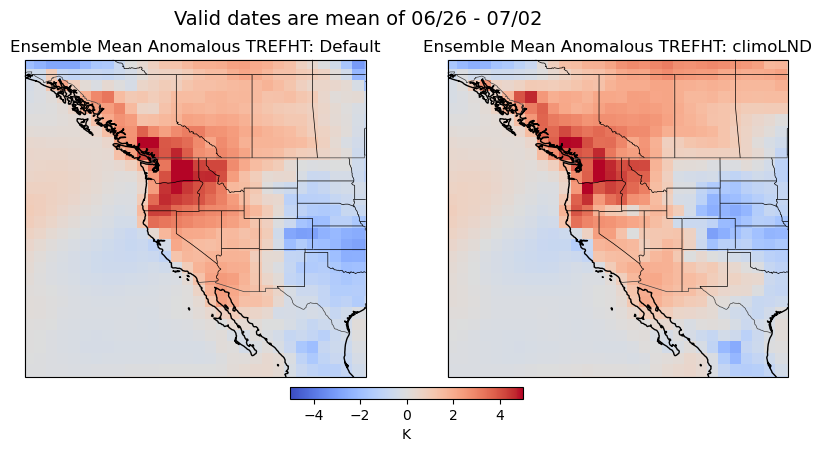

In [37]:
fig,axs = plt.subplots(1,2, figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs     = axs.ravel()

[a.coastlines() for a in axs]
[a.set_extent([220,265,20,60]) for a in axs]
[a.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') for a in axs]
[a.add_feature(states_provinces,edgecolor='k',linewidth=0.5) for a in axs]

fig.text(0.28,0.95,'Valid dates are mean of 06/26 - 07/02 ',fontsize=14)
# fig.text(0.28,0.95,'Valid dates are mean of 06/28 - 07/04 ',fontsize=14)

# Plot ens mean 
axs[0].pcolormesh(longrid_anom,latgrid_anom, np.squeeze(anom_default_0621.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[0].set_title('Ensemble Mean Anomalous TREFHT: Default')

p1 =axs[1].pcolormesh(longrid_anom2,latgrid_anom2, np.squeeze(anom_climLnd_0621.mean(dim='member').values), 
                  cmap='coolwarm', norm=normVar_anom, transform=ccrs.PlateCarree())
axs[1].set_title('Ensemble Mean Anomalous TREFHT: climoLND')
# Add colorbar
cb = fig.colorbar(p1, ax=axs[0:2], shrink=0.3, label='K', orientation='horizontal', pad=0.025) 



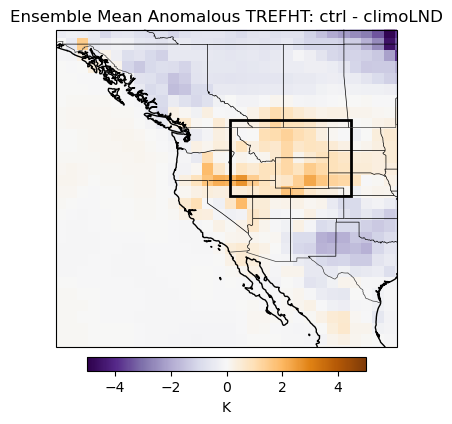

In [38]:
fig,axs = plt.subplots(1,1, figsize=(12,5),subplot_kw={'projection':ccrs.PlateCarree()})


axs.coastlines()
axs.set_extent([220,265,20,60]) 
axs.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25') 
axs.add_feature(states_provinces,edgecolor='k',linewidth=0.5) 


p1 =axs.pcolormesh(longrid_anom,latgrid_anom, 
                   np.squeeze(anom_default_0621.mean(dim='member').values)- np.squeeze(anom_climLnd_0621.mean(dim='member').values), 
                  cmap='PuOr_r', norm=normVar_anom, transform=ccrs.PlateCarree())
axs.set_title('Ensemble Mean Anomalous TREFHT: ctrl - climoLND')
# Add colorbar
cb = fig.colorbar(p1, ax=axs, shrink=0.3, label='K', orientation='horizontal', pad=0.025) 

# Add rectangle?
axs.add_patch(patches.Rectangle(xy=[243, 40], width=(259-243), height=(50-40),
                                facecolor='none', edgecolor='k',linestyle='-',
                                linewidth=2, transform=ccrs.PlateCarree()))